# 1. Import Model Predictions and References

In [1]:
!gdown 1H90cpSxm0STukFocsWgl-mMoaph2IrV7
!gdown 1S5Nj-EdWbxzguMGQBm3z7oQV3Z8ujfze
!gdown 1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb

Downloading...
From: https://drive.google.com/uc?id=1H90cpSxm0STukFocsWgl-mMoaph2IrV7
To: /content/strong_test_pred.txt
100% 52.0k/52.0k [00:00<00:00, 67.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S5Nj-EdWbxzguMGQBm3z7oQV3Z8ujfze
To: /content/pegasus_test_pred.txt
100% 41.9k/41.9k [00:00<00:00, 36.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb
To: /content/test.csv
100% 777k/777k [00:00<00:00, 46.4MB/s]


In [2]:
%%capture
!pip install --upgrade accelerate
!pip install evaluate
!pip install bert_score

In [8]:
import pandas as pd
from evaluate import load
import matplotlib.pyplot as plt

In [4]:
def construct_list(file):
  with open(file, "r") as f:
      lines = f.readlines()
      lines = [line.strip() for line in lines]
  return lines

In [35]:
pegasus_preds = construct_list("pegasus_test_pred.txt")
t5_preds = construct_list("strong_test_pred.txt")
test_df = pd.read_csv("test.csv")
references = test_df["summary"].tolist()

# 2. Evaluation Metrics

We will use Bert Score to compare the quality of different summaries

In [6]:
bertscore = load("bertscore")
def evaluate_bert(predictions, references):
  return bertscore.compute(predictions=predictions,
                           references=references,
                           rescale_with_baseline=True,
                           lang='en')['f1']

In [7]:
strong_pred_bert = evaluate_bert(t5_preds, references)
pegasus_pred_bert = evaluate_bert(pegasus_preds, references)

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


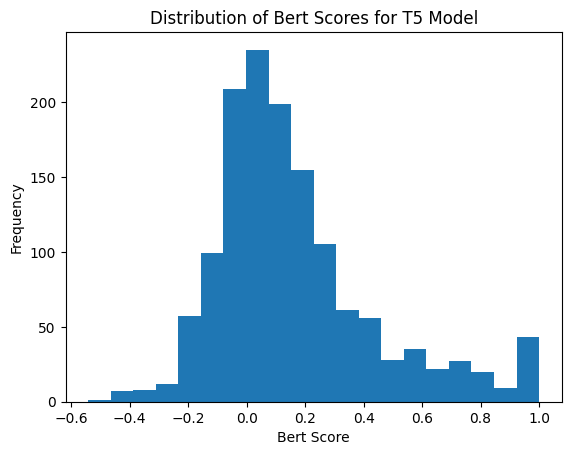

In [17]:
plt.hist(strong_pred_bert, bins=20)
plt.xlabel('Bert Score')
plt.ylabel('Frequency')
plt.title('Distribution of Bert Scores for T5 Model')

plt.show()

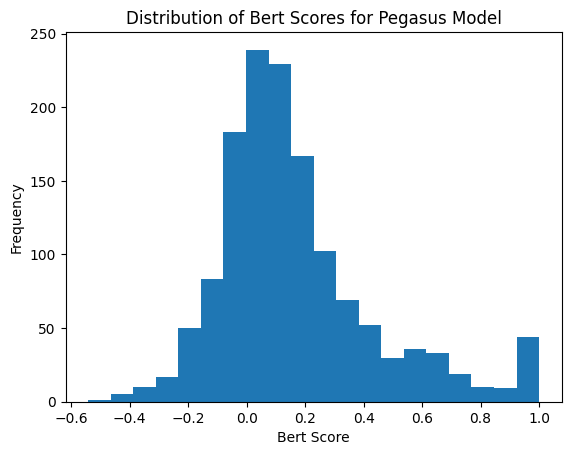

In [18]:
plt.hist(pegasus_pred_bert, bins=20)
plt.xlabel('Bert Score')
plt.ylabel('Frequency')
plt.title('Distribution of Bert Scores for Pegasus Model')

plt.show()

# 3. Identifying Good and Poor Summaries
We can see from the graph that there are some negative bert scores for summaries in both models. We will look mainly look at these examples

## Pegasus

In [107]:
good_summaries_indices = [i for i, score in enumerate(pegasus_pred_bert) if score > 0.5]

In [108]:
len(good_summaries_indices)

164

In [109]:
good_predictions = [pegasus_preds[i] for i in good_summaries_indices]
good_references = [references[i] for i in good_summaries_indices]
good_reviews = [test_df['reviewText'][i] for i in good_summaries_indices]

In [110]:
good_df = pd.DataFrame({'review': good_reviews, 'references': good_references, 'predictions': good_predictions})

In [112]:
good_df.iloc[0]['review']

'I bought these for my wife. She saw them in the store but did not have their size so i ordered on amazon. She loves them . She already had for a couple of months and no complains at all. One of her favorites shoes for running or for her job since she walks a lot in the warehouse. Now she loves me more. :)'

In [90]:
poor_summaries_indices = [i for i, score in enumerate(pegasus_pred_bert) if score < -0.35]

In [91]:
len(poor_summaries_indices)

11

In [92]:
poor_predictions = [pegasus_preds[i] for i in poor_summaries_indices]
poor_references = [references[i] for i in poor_summaries_indices]
poor_reviews = [test_df['reviewText'][i] for i in poor_summaries_indices]

In [113]:
poor_df = pd.DataFrame({'review': poor_reviews, 'references': poor_references, 'predictions': poor_predictions})

In [114]:
poor_df

,review,references,predictions
0,I can remember watching my grandma iron clothe...,wonderul light French Lavender blossom spray,"Fresh, Fresh, Fresh!"
1,This is an old time favorite from back in the ...,"Stevie Wonder, Isnt She Lovely",Old time favorite
2,I love the album for the simple joy of remindi...,Memeories,"Great song, great band"
3,Where have all the flowers gone? Hmm I would s...,ZZZZZzzzzzzz.....,Where have all the flowers gone?
4,"My friend-----the ""handy man""-----lives THOUSA...",HIGHLY RECOMMENDED gift!,"My friend------the ""handy man""-----lives THOUS..."
5,This is my 2nd favorite tea and is difficult t...,Oolong,This is my 2nd favorite tea
6,Have grown to love this crusty old sheriff and...,Walt Longmire,Have grown to love this crusty old sheriff
7,I really loved Heathers Dirty Blood series so ...,AWESOMESAUCE,I am in love with this book!
8,All the latest news about the world of Movies...,Informative Entertainment,All the latest news about the world of Movies
9,good price for this size of fabric softener,Downey Liquid Fabric Softener,good price for this size


## Improvements from T5

In [86]:
improved_summaries_indices = [
    i for i, (score1, score2) in enumerate(zip(strong_pred_bert, pegasus_pred_bert))
    if score1 < -0.1 and score2 > 0.2
]

In [87]:
len(improved_summaries_indices)

6

In [88]:
old_predictions = [t5_preds[i] for i in improved_summaries_indices]
new_predictions = [pegasus_preds[i] for i in improved_summaries_indices]
improved_references = [references[i] for i in improved_summaries_indices]
improved_reviews = [test_df['reviewText'][i] for i in improved_summaries_indices]

In [116]:
improved_df = pd.DataFrame({'review': improved_reviews, 'references': improved_references, 'old_predictions': old_predictions, 'new_predictions': new_predictions})

In [119]:
improved_df

,review,references,old_predictions,new_predictions
0,I bought this bracket in order to work with my...,Don't let the cost sway you...it works!,SOLID,Works perfect!
1,Worked perfectly. P.F. Chang's is soooo good a...,Chang's is soooo good and I love the environme...,Worked perfectly,P.F Chang's is soooo good and I love the envir...
2,Bought as a lightning deal and received it pro...,Worked,Good value for money,It worked.
3,sucks better than I do lolol,Great vac!,better than I do lolol,sucks better
4,This steel tweezers is very well made. With it...,excellent for fine work,Great tweezer,Very well made.
5,These are just what your looking for. I was ve...,Perfect Hot water heater Timer,These are just what your looking for,Great Timers!


In [118]:
list(improved_df['review'])

['I bought this bracket in order to work with my 700-R4 GM transmission with my Holley 670 Street Avenger carburetor.  At first, I thought it was crazy to spend that much when they make cheaper universal brackets.  DO NOT use a universal bracket.  They are cheap, and flimsy.  This product is SOLID.  It is very sturdy, matches up to the carburetor perfectly and does not bend, sway, move, etc.  Works perfect!!!',
 "Worked perfectly. P.F. Chang's is soooo good and I love the environment there.",
 'Bought as a lightning deal and received it promptly. It worked when I went to use it.',
 'sucks better than I do lolol',
 "This steel tweezers is very well made. With its needle point and tapered design, it is intended for fine work. For example, picking up very small screws when working on eyeglasses or a watch. The length and tapered design let you easily pick up and hold in place a screw with the tweezers while using a precision screwdriver to tighten the screw in place.\n\nA safety note: As 

In [120]:
list(improved_df['references'])

["Don't let the cost sway you...it works!",
 "Chang's is soooo good and I love the environment there",
 'Worked',
 'Great vac!',
 'excellent for fine work',
 'Perfect Hot water heater Timer']

In [121]:
list(improved_df['new_predictions'])

['Works perfect!',
 "P.F Chang's is soooo good and I love the environment there",
 'It worked.',
 'sucks better',
 'Very well made.',
 'Great Timers!']